In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster

client = Client() # Note that `memory_limit` is the limit **per worker**.
# n_workers=4,
#                 threads_per_worker=1,
#                 memory_limit='3GB'
client # If you click the dashboard link in the output, you can monitor real-time progress and get other cool visualizations.

/Users/abroome/opt/miniconda3/envs/sprinkles/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65234 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:65234/status,
Dashboard: http://127.0.0.1:65234/status,Workers: 4
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65235,Workers: 4
Dashboard: http://127.0.0.1:65234/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:65250,Total threads: 4
Dashboard: http://127.0.0.1:65253/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:65238,


In [3]:
import os
import copy
import sys
import xarray as xr
import numpy as np
import dask.array as da

import matplotlib.pyplot as plt
import hvplot.xarray
import scipy.constants

sys.path.append("..")
import processing_dask as pr
import plot_dask
import processing as old_processing

sys.path.append("../../preprocessing/")
from generate_chirp import generate_chirp

In [26]:
# file path to data and configs

#prefix = "/home/radioglaciology/thomas/radar_data/20220903-vatnajokull-day4/20220903_033000" # Vatnajokull flight
#prefix = "/home/radioglaciology/thomas/radar_data/20230315-slakbreen-day3/20230315_064228" # Slakbreen flight


#prefix = "/home/radioglaciology/thomas/radar_data/20230721-summit-day1-bench/20230721_104552"
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_103641"
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_103845" # 6 db higher tx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104059"
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104248" # another 6 db
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104456" # 3db higher rx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104742" # 20 -> 30 mhz chirp bw
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_105025" # bw back to 20, 15 mhz lo offset
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_105509" # 100k pulses, 30 us transmit, 90 us rx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_105921" # 100k pulses, 10 us transmit, 90 us rx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_110253" # 100k pulses, 5 us transmit, 60 us rx

#prefix = "/media/radioglaciology/Extreme SSD/summit_2023_mapper/20230723_151432" # 20 us transmit
#prefix = "/media/radioglaciology/Extreme SSD/summit_2023_mapper/20230723_153254" # 10 us transmit
#prefix = "/media/radioglaciology/Extreme SSD/summit_2023_mapper/20230723_152404" #  5 us transmit

#prefix = "/media/radioglaciology/Extreme SSD/summit_2023_mapper/07252023/20230725_161051" # mapper

prefix = "/Volumes/Extreme SSD/Summit2023/07232023_anna/20230723_151432"
#prefix = "/Volumes/Extreme SSD/Summit2023/07252023_anna/20230725_141923"



# resave data as zarr for dask processing
zarr_path = pr.save_radar_data_to_zarr(prefix, zarr_base_location="/Volumes/Extreme SSD/Summit2023/07232023_anna/zarrs/")

# open zarr file, adjust chunk size to be 10 MB - 1 GB based on sample rate/bit depth
raw = xr.open_zarr(zarr_path, chunks={"pulse_idx": 1000})

/Users/abroome/opt/miniconda3/envs/sprinkles/lib/python3.9/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "pulse_idx" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [27]:
n_stack = 1000
stacked = pr.stack(raw.chunk({'sample_idx': 1000}), n_stack).chunk({'sample_idx': -1})

In [34]:
start_time = 25e-6 # 3e5
input_data = stacked["radar_data"].where(stacked.fast_time.compute() >= start_time, drop=True) #.where(stacked.slow_time <= 115, drop=True).where(stacked.slow_time >= 95, drop=True)

f, t, S = scipy.signal.spectrogram(
    input_data.to_numpy().T.flatten(),
    fs=raw.attrs["config"]["GENERATE"]["sample_rate"],
    window='flattop',
    nperseg=input_data.shape[0],
    noverlap=0,
    scaling='density', mode='psd',
    return_onesided=False
)

Text(0.5, 1.0, '20230723_151432\nSpectrogram of received data with n_stack=1000,\ntime gated to >=2.5e-05 s fast time')

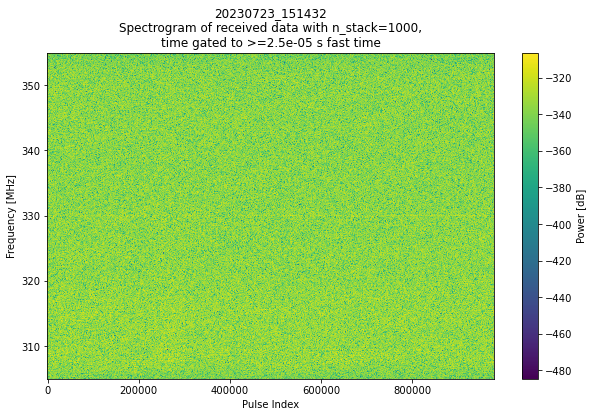

In [35]:
fig, ax = plt.subplots(facecolor='white', figsize=(10,6))
freq_mhz = (np.fft.fftshift(f) + raw.attrs['config']['RF0']['freq']) / 1e6
pcm = ax.pcolormesh(input_data.pulse_idx, freq_mhz, 20*np.log10(np.abs(np.fft.fftshift(S, axes=0))), shading='nearest')#, vmin=-400, vmax=-200)
clb = fig.colorbar(pcm, ax=ax)
clb.set_label('Power [dB]')
#ax.set_xlabel('Slow Time [s]')
ax.set_xlabel('Pulse Index')
ax.set_ylabel('Frequency [MHz]')
ax.set_title(f"{os.path.basename(stacked.prefix)}\nSpectrogram of received data with n_stack={n_stack},\ntime gated to >={start_time} s fast time")
#ax.set_xlim(0, 1e-5)
#ax.set_xlim(50000, 100000)

In [33]:
fig.savefig(f"/Users/abroome/Desktop/Summit2023/figs/{raw.basename}-spectrogram-st-stack{n_stack}_gating.png")

In [ ]:
test = pr.stack(raw, 10)
test.pulse_idx[1] - test.pulse_idx[0]